# Projeto german credit risk - modelagem e avaliação

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, precision_score, recall_score, precision_recall_curve
import numpy as np

from pathlib import Path

In [40]:
DATA_DIR = Path.cwd().parent / 'data'

In [41]:
data_encoded = pd.read_csv(DATA_DIR / 'data_encoded.csv')
data_encoded.shape

(1000, 42)

In [42]:
# Split estratificado pela variável dependente

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data_encoded, data_encoded["target"]):
    strat_train_set = data_encoded.loc[train_index]
    strat_test_set = data_encoded.loc[test_index]

print(strat_train_set.shape)
print(strat_test_set.shape)

(800, 42)
(200, 42)


In [43]:
# Separando variáveis dependentes e independentes

dataset_features = strat_train_set.drop("target", axis=1)
test_features = strat_test_set.drop("target", axis=1)
dataset_labels = strat_train_set["target"].copy()
test_labels = strat_test_set["target"].copy()

In [44]:
# Transformando as labels em booleanos (True para good customer e False para bad customer)

dataset_labels = (dataset_labels == 1)
test_labels = (test_labels == 1)

### Métrica escolhida: Acurácia, priorizando Precisão ("It is worse to class a customer as good when they are bad (5), than it is to class a customer as bad when they are good (1).")

In [45]:
class TrivialClassifier(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.ones((len(X), 1), dtype=bool)

In [46]:
# Modelos preliminares (sem scaling, sem feature selection, sem hyperparameter tuning, etc)

trivial = TrivialClassifier()
smv_lin = SVC(kernel="linear", random_state=42)
svm_poly = SVC(kernel="poly", random_state=42)
smv_rbf = SVC(kernel="rbf", random_state=42)
rfc = RandomForestClassifier(random_state=42)
knn = KNeighborsClassifier()
sgd = SGDClassifier(random_state=42)

models = [trivial, smv_lin, svm_poly, smv_rbf, rfc, knn, sgd]

In [47]:
for model in models:
    model.fit(dataset_features, dataset_labels)
    scores = cross_val_score(model, dataset_features, dataset_labels, scoring="accuracy", cv=10)
    print(model, scores.mean())

TrivialClassifier() 0.7


SVC(kernel='linear', random_state=42) 0.76125
SVC(kernel='poly', random_state=42) 0.74875
SVC(random_state=42) 0.7475
RandomForestClassifier(random_state=42) 0.755
KNeighborsClassifier() 0.73
SGDClassifier(random_state=42) 0.7075


In [48]:
# Otimizar o hiperparametro C do SVM linear com GridSearchCV

param_grid = [
    {'C': [5, 10, 15, 20]}
]

svm_lin = SVC(kernel="linear", random_state=42)
grid_search = GridSearchCV(svm_lin, param_grid, cv=10, scoring='accuracy', return_train_score=True)
grid_search.fit(dataset_features, dataset_labels)

print(grid_search.best_params_)
print(grid_search.best_estimator_)
print(grid_search.best_score_)
print(grid_search.cv_results_)

{'C': 10}
SVC(C=10, kernel='linear', random_state=42)
0.765
{'mean_fit_time': array([0.06272113, 0.09764657, 0.12909291, 0.16961341]), 'std_fit_time': array([0.0136026 , 0.03174012, 0.02838571, 0.05526962]), 'mean_score_time': array([0.00174599, 0.00288913, 0.00159662, 0.00220697]), 'std_score_time': array([0.00190013, 0.00155036, 0.00195577, 0.00191976]), 'param_C': masked_array(data=[5, 10, 15, 20],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 5}, {'C': 10}, {'C': 15}, {'C': 20}], 'split0_test_score': array([0.775 , 0.7875, 0.7875, 0.775 ]), 'split1_test_score': array([0.75, 0.75, 0.75, 0.75]), 'split2_test_score': array([0.675, 0.675, 0.675, 0.675]), 'split3_test_score': array([0.8125, 0.8125, 0.8125, 0.8125]), 'split4_test_score': array([0.8125, 0.8125, 0.8   , 0.8   ]), 'split5_test_score': array([0.775, 0.775, 0.775, 0.775]), 'split6_test_score': array([0.825, 0.825, 0.825, 0.825]), 'split7_test_score': array([

In [49]:
svc_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="linear", C=10, random_state=42))
])

In [50]:
final_model = svc_pipe.fit(dataset_features, dataset_labels)

In [51]:
y_scores = cross_val_predict(
    final_model,
    dataset_features,
    dataset_labels,
    cv=3,
    method="decision_function",
    n_jobs=-1,
)

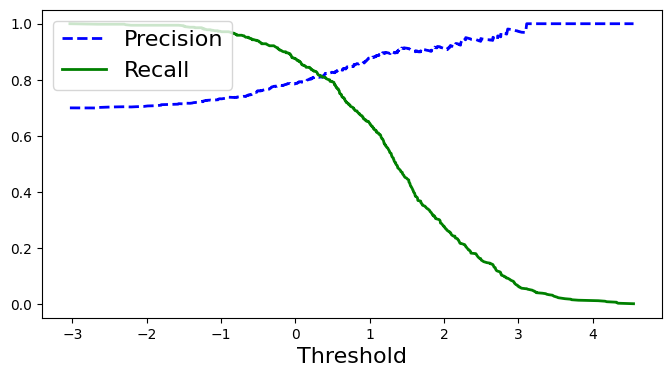

In [52]:
precisions, recalls, thresholds = precision_recall_curve(dataset_labels, y_scores)

plt.figure(figsize=(8, 4))

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)

plt.xlabel("Threshold", fontsize=16)
plt.legend(loc="upper left", fontsize=16)
plt.show()

In [53]:
# Queremos um threshold que garanta um precision de 90%

threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
threshold_90_precision

1.3751787971412561

In [54]:
print('Precision: {}'.format(precision_score(dataset_labels, y_scores >= threshold_90_precision)))
print('Recall: {}'.format(recall_score(dataset_labels, y_scores >= threshold_90_precision)))

Precision: 0.9013157894736842
Recall: 0.48928571428571427


In [55]:
# Testando o modelo final no conjunto de teste

final_predictions = final_model.predict(test_features)
print('Precision: {}'.format(precision_score(test_labels, final_predictions)))
print('Recall: {}'.format(recall_score(test_labels, final_predictions)))

Precision: 0.8051948051948052
Recall: 0.8857142857142857


### Salvar o modelo final em formato pickle

In [56]:
import joblib

joblib.dump(final_model, "final_model.pkl")

['final_model.pkl']